# Couverture connexe minimum dans un réseau de capteurs

Pipeline : modélisation → heuristique → voisinages → métaheuristique → expériences.

## Problème
- On a des **cibles** (points) où l'on peut placer des capteurs.
- Un capteur placé sur une cible **couvre** toutes les cibles à distance ≤ `Rcapt`.
- Deux capteurs peuvent **communiquer** si leur distance ≤ `Rcom`.
- Il existe un **puits** (sink) : **chaque capteur** doit pouvoir atteindre le puits via un chemin de communications.
- Objectif : **minimiser le nombre de capteurs**.

## Approche implémentée
1. **Pré-calculs** (voisinages de captation, graphe de communication, plus courts chemins depuis le puits).
2. **Heuristique constructive** : glouton basé sur le score `nouvelle_couverture / (1 + coût_connexion)`.
3. **Réparation** : compléter la couverture puis raccorder au puits si besoin.
4. **Amélioration locale** : *pruning* (suppression de capteurs inutiles) + petits swaps.
5. **Métaheuristique** : **VNS** (Variable Neighborhood Search) avec perturbations `k-remove + repair`.

## Contexte et objectif

On cherche a placer un minimum de capteurs pour couvrir toutes les cibles et garder une connexion vers un puits.
Le probleme combine donc **couverture geometrique** (rayon RCAPT) et **connectivite** (rayon RCOM).
C'est un probleme NP-difficile, donc on vise des **heuristiques / metaheuristiques**.


In [121]:
import math
import random
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)

## 1) Instances

### Formats supportés
- **Grille** `n x m` : toutes les cibles sont présentes.
- **Grille tronquée** : on enlève des rectangles (plages de cibles supprimées).
- **Fichier coordonnées** : on lit des lignes contenant des nombres (id optionnel) et on récupère `(x, y)`.

Le puits est par défaut au point `(0,0)` 

### Modelisation des donnees

Chaque cible est un point 2D. On autorise un capteur a etre place sur n'importe quelle cible.
Le puits est un point fixe, pas forcement sur la grille.


In [122]:
@dataclass
class Instance:
    coords: np.ndarray          # shape (N, 2)
    sink: Tuple[float, float]   # (x, y)
    name: str = "instance"

def make_grid(n: int, m: int, sink: Tuple[float, float]=(0.0, 0.0), name: str="grid") -> Instance:
    # Coordonnées sur une grille unité (1..n, 1..m) ou (0..n-1,0..m-1) : ici on prend (0..)
    xs, ys = np.meshgrid(np.arange(m), np.arange(n))
    coords = np.column_stack([xs.ravel(), ys.ravel()]).astype(float)
    return Instance(coords=coords, sink=sink, name=f"{name}_{n}x{m}")

def make_truncated_grid(n: int, m: int, holes: List[Tuple[int,int,int,int]], sink: Tuple[float,float]=(0.0,0.0), name: str="trunc") -> Instance:
    # holes: liste de rectangles (r0,r1,c0,c1) en indices [r0,r1) x [c0,c1)
    mask = np.ones((n, m), dtype=bool)
    for r0, r1, c0, c1 in holes:
        mask[r0:r1, c0:c1] = False
    coords = []
    for r in range(n):
        for c in range(m):
            if mask[r, c]:
                coords.append((c, r))
    coords = np.array(coords, dtype=float)
    return Instance(coords=coords, sink=sink, name=f"{name}_{n}x{m}_holes{len(holes)}")

def load_points_txt(path: str, sink: Tuple[float,float]=(0.0,0.0), name: Optional[str]=None) -> Instance:
    # Parser robuste: prend les 2 derniers nombres sur chaque ligne (ou les 2 premiers si seulement 2)
    pts = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            # Extraire tous les tokens qui ressemblent à des nombres
            toks = []
            for t in line.replace(',', ' ').split():
                try:
                    toks.append(float(t))
                except ValueError:
                    pass
            if len(toks) >= 2:
                x, y = toks[-2], toks[-1]
                pts.append((x, y))
    coords = np.array(pts, dtype=float)
    if name is None:
        name = Path(path).stem
    return Instance(coords=coords, sink=sink, name=name)


### Visualisation rapide d'une instance

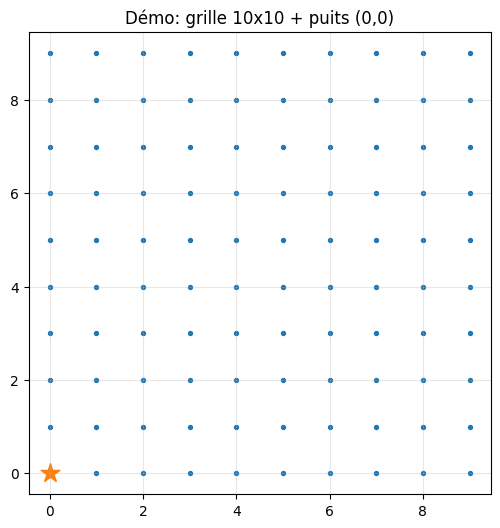

In [123]:
def plot_instance(inst: Instance, title: Optional[str]=None):
    xy = inst.coords
    plt.figure(figsize=(6,6))
    plt.scatter(xy[:,0], xy[:,1], s=8)
    plt.scatter([inst.sink[0]], [inst.sink[1]], marker='*', s=200)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, alpha=0.3)
    plt.title(title or inst.name)
    plt.show()

inst_demo = make_grid(10, 10)
plot_instance(inst_demo, 'Démo: grille 10x10 + puits (0,0)')

## 2) Pré-calculs: captation / communication / plus courts chemins

On pré-calcule :
- `cover[v]` = liste des cibles couvertes si on place un capteur sur la cible `v`.
- `com_adj` = liste d'adjacence du graphe de communication sur **(N cibles + 1 puits)**.
- `parent` = parents BFS depuis le puits (pour reconstruire un chemin rapide pour raccorder).

Notes perf : jusqu'à ~1600 cibles, une matrice de distances au carré reste raisonnable (~2.5M).

In [124]:
@dataclass
class Precomp:
    inst: Instance
    Rcapt: float
    Rcom: float
    cover: List[np.ndarray]           # cover[v] -> indices des cibles couvertes
    com_adj: List[List[int]]          # adjacency sur N+1 noeuds (dernier = puits)
    sink_index: int                   # = N
    parent_from_sink: List[int]       # BFS parent, taille N+1

def build_precomp(inst: Instance, Rcapt: float, Rcom: float) -> Precomp:
    coords = inst.coords
    N = coords.shape[0]
    sink = np.array(inst.sink, dtype=float)
    all_coords = np.vstack([coords, sink[None, :]])  # N+1

    # Distances au carré
    # (N+1)x(N+1)
    diff = all_coords[:, None, :] - all_coords[None, :, :]
    dist2 = np.einsum('ijk,ijk->ij', diff, diff)

    Rcapt2 = Rcapt * Rcapt
    Rcom2 = Rcom * Rcom

    # Couverture: uniquement pour les cibles (pas le puits)
    cover = []
    for v in range(N):
        covered = np.where(dist2[v, :N] <= Rcapt2)[0]
        cover.append(covered.astype(int))

    # Graphe de communication sur N+1 noeuds
    com_adj = [[] for _ in range(N+1)]
    for i in range(N+1):
        neigh = np.where((dist2[i] <= Rcom2) & (np.arange(N+1) != i))[0]
        com_adj[i] = neigh.astype(int).tolist()

    sink_index = N

    # BFS depuis le puits sur le graphe complet
    parent = [-1] * (N+1)
    parent[sink_index] = sink_index
    q = deque([sink_index])
    while q:
        u = q.popleft()
        for w in com_adj[u]:
            if parent[w] == -1:
                parent[w] = u
                q.append(w)

    return Precomp(inst=inst, Rcapt=Rcapt, Rcom=Rcom, cover=cover, com_adj=com_adj,
                   sink_index=sink_index, parent_from_sink=parent)


### Graphiques: structure locale

Deux histogrammes utiles pour comprendre l'instance :
- le nombre de voisins de communication (degre du graphe RCOM),
- le nombre de cibles couvertes par un capteur (degre de couverture RCAPT).

Notes :
- Si la distribution des degres est etalee, certaines zones sont denses et d'autres isolees.
- Un degre moyen faible en RCOM indique qu'il faudra souvent ajouter des relais pour connecter au puits.
- Un degre moyen eleve en RCAPT signifie que peu de capteurs peuvent couvrir beaucoup de cibles.


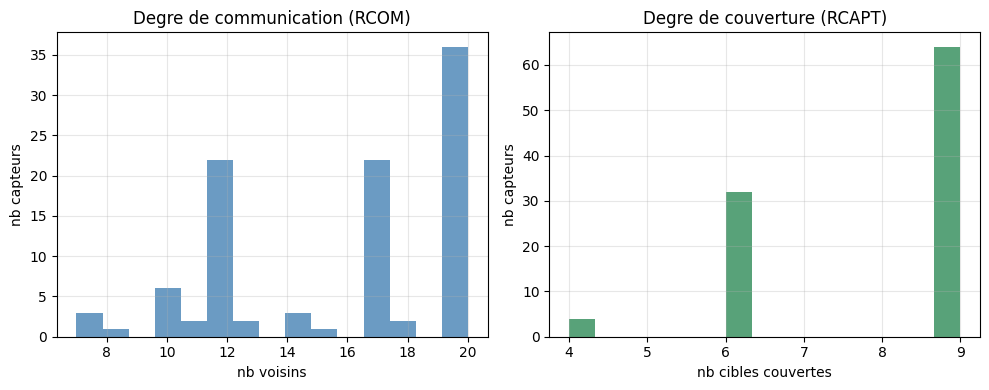

In [125]:
# Histogrammes de degres (communication + couverture) sur une petite instance
pc_demo = build_precomp(inst_demo, Rcapt=1.5, Rcom=2.5)
N = pc_demo.inst.coords.shape[0]

deg_com = [len(pc_demo.com_adj[i]) for i in range(N)]
deg_cov = [len(pc_demo.cover[i]) for i in range(N)]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(deg_com, bins=15, color='steelblue', alpha=0.8)
ax[0].set_title('Degre de communication (RCOM)')
ax[0].set_xlabel('nb voisins')
ax[0].set_ylabel('nb capteurs')
ax[0].grid(True, alpha=0.3)

ax[1].hist(deg_cov, bins=15, color='seagreen', alpha=0.8)
ax[1].set_title('Degre de couverture (RCAPT)')
ax[1].set_xlabel('nb cibles couvertes')
ax[1].set_ylabel('nb capteurs')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3) Évaluation / faisabilité

Deux modes :
- **Strict faisable** : on impose couverture + connexité.
- **Fitness pénalisée** : accepte temporairement de l'infaisable.

Ici on fait surtout **faisable + repair**, c'est plus stable.

In [126]:
def is_connected_to_sink(selected: np.ndarray, pc: Precomp) -> bool:
    # selected: bool array taille N (capteurs)
    N = pc.inst.coords.shape[0]
    sink = pc.sink_index

    # noeuds actifs: capteurs + sink
    active = np.zeros(N+1, dtype=bool)
    active[:N] = selected
    active[sink] = True

    # BFS depuis sink dans le sous-graphe induit
    seen = np.zeros(N+1, dtype=bool)
    q = deque([sink])
    seen[sink] = True
    while q:
        u = q.popleft()
        for w in pc.com_adj[u]:
            if active[w] and not seen[w]:
                seen[w] = True
                q.append(w)

    # Tous les capteurs doivent être vus
    return bool(np.all(seen[:N][selected]))

def compute_coverage_counts(selected: np.ndarray, pc: Precomp) -> np.ndarray:
    N = pc.inst.coords.shape[0]
    cov = np.zeros(N, dtype=int)
    idx = np.where(selected)[0]
    for v in idx:
        cov[pc.cover[v]] += 1
    return cov

def is_fully_covered(selected: np.ndarray, pc: Precomp) -> bool:
    cov = compute_coverage_counts(selected, pc)
    return bool(np.all(cov > 0))

def is_feasible(selected: np.ndarray, pc: Precomp) -> bool:
    return is_fully_covered(selected, pc) and is_connected_to_sink(selected, pc)

def fitness_penalized(selected: np.ndarray, pc: Precomp, lam_cov: float=10.0, lam_con: float=10.0) -> float:
    N = pc.inst.coords.shape[0]
    nb = int(selected.sum())
    cov = compute_coverage_counts(selected, pc)
    uncovered = int(np.sum(cov == 0))
    connected = is_connected_to_sink(selected, pc)
    disconnected = 0 if connected else 1
    return nb + lam_cov * uncovered + lam_con * disconnected

## 4) Outils: reconstruction de chemin vers le puits

On utilise le BFS pré-calculé sur le graphe complet pour reconstruire un plus court chemin communication vers le puits.
Ça sert à **raccorder rapidement** une cible au réseau (en ajoutant des relais).

In [127]:
def path_to_sink(node: int, pc: Precomp) -> List[int]:
    # renvoie [node, ..., sink]
    parent = pc.parent_from_sink
    sink = pc.sink_index
    if node == sink:
        return [sink]
    if parent[node] == -1:
        return []
    path = [node]
    cur = node
    while cur != sink:
        cur = parent[cur]
        if cur == -1:
            return []
        path.append(cur)
    return path

## 5) Heuristique constructive (glouton profit / coût connexion)

Idée : on ajoute des capteurs jusqu'à couvrir tout le monde.

Score d'un candidat `v` :
- `gain = nb_cibles_non_couvertes` que `v` couvre.
- `cost = nb_relais` à ajouter pour relier `v` au puits (via le chemin BFS).
- `score = gain / (1 + cost)`

Puis on finit avec un **pruning** (suppression de capteurs inutiles).

In [128]:
def greedy_construct(pc: Precomp, max_iters: int=100000) -> np.ndarray:
    N = pc.inst.coords.shape[0]
    selected = np.zeros(N, dtype=bool)
    cov = np.zeros(N, dtype=int)

    uncovered = set(range(N))

    it = 0
    while uncovered and it < max_iters:
        it += 1
        best_v = None
        best_score = -1.0
        best_gain = 0
        best_cost = 10**9

        # Pour accélérer, on échantillonne si N est grand
        candidates = list(uncovered)
        if len(candidates) > 600:
            candidates = random.sample(candidates, 600)

        for v in candidates:
            if selected[v]:
                continue
            covered_targets = pc.cover[v]
            gain = int(np.sum(cov[covered_targets] == 0))
            if gain == 0:
                continue

            # coût de connexion approximé: nombre de noeuds du chemin qui ne sont pas déjà sélectionnés
            p = path_to_sink(v, pc)
            if not p:
                continue
            # p contient aussi le sink (index N), qu'on n'ajoute pas
            cost = 0
            for node in p[:-1]:
                if node < N and not selected[node] and node != v:
                    cost += 1

            score = gain / (1.0 + cost)
            if score > best_score or (score == best_score and gain > best_gain) or (score == best_score and gain == best_gain and cost < best_cost):
                best_v = v
                best_score = score
                best_gain = gain
                best_cost = cost

        if best_v is None:
            # fallback : prendre une cible non couverte au hasard
            best_v = next(iter(uncovered))

        # Ajouter le capteur best_v
        selected[best_v] = True
        cov[pc.cover[best_v]] += 1
        for t in pc.cover[best_v]:
            uncovered.discard(int(t))

        # Option : si best_v est loin du puits, ajouter aussi les relais pour faciliter la suite
        p = path_to_sink(best_v, pc)
        for node in p[:-1]:
            if node < N and not selected[node]:
                selected[node] = True
                cov[pc.cover[node]] += 1
                for t in pc.cover[node]:
                    uncovered.discard(int(t))

    return selected

## 6) Réparation (coverage + connexité)

Après perturbation (ou swap), la solution peut devenir infaisable :
- la couverture,
- la connexité.

Repair = (1) réparer la couverture (glouton max gain) (2) relier au puits en ajoutant des relais sur des plus courts chemins.

Ensuite on prune.

In [129]:
def repair_coverage(selected: np.ndarray, pc: Precomp) -> np.ndarray:
    N = pc.inst.coords.shape[0]
    sel = selected.copy()
    cov = compute_coverage_counts(sel, pc)

    uncovered = np.where(cov == 0)[0]
    uncovered_set = set(uncovered.tolist())

    # Glouton : ajouter le capteur qui couvre le plus d'uncovered
    while uncovered_set:
        best_v, best_gain = None, -1

        # candidats : on peut se limiter aux cibles non couvertes
        candidates = list(uncovered_set)
        if len(candidates) > 600:
            candidates = random.sample(candidates, 600)

        for v in candidates:
            if sel[v]:
                continue
            gain = 0
            for t in pc.cover[v]:
                if int(t) in uncovered_set:
                    gain += 1
            if gain > best_gain:
                best_gain = gain
                best_v = v

        if best_v is None:
            best_v = next(iter(uncovered_set))

        sel[best_v] = True
        cov[pc.cover[best_v]] += 1
        for t in pc.cover[best_v]:
            uncovered_set.discard(int(t))

    return sel

def repair_connectivity(selected: np.ndarray, pc: Precomp) -> np.ndarray:
    N = pc.inst.coords.shape[0]
    sel = selected.copy()

    # Si déjà connecté, rien à faire
    if is_connected_to_sink(sel, pc):
        return sel

    # Stratégie simple: pour chaque capteur non connecté, ajouter son chemin vers le puits
    # (on fait quelques passes, car ajouter des relais peut connecter plein de monde)
    for _ in range(3):
        if is_connected_to_sink(sel, pc):
            break
        idx = np.where(sel)[0]
        random.shuffle(idx.tolist())
        for v in idx:
            # si v n'est pas connectable via le parent (cas rare si graphe global connexe), on ignore
            p = path_to_sink(int(v), pc)
            for node in p[:-1]:
                if node < N:
                    sel[node] = True
    return sel

def repair(selected: np.ndarray, pc: Precomp) -> np.ndarray:
    sel = repair_coverage(selected, pc)
    sel = repair_connectivity(sel, pc)
    # Une fois connecté, on prune
    sel = prune_redundant(sel, pc)
    return sel

## 7) Pruning : supprimer des capteurs inutiles

On enlève des capteurs tant que :
- la couverture reste complète,
- le graphe reste connecté au puits.

On le fait en boucle jusqu'à stabilisation.

In [130]:
def prune_redundant(selected: np.ndarray, pc: Precomp, max_passes: int=5) -> np.ndarray:
    N = pc.inst.coords.shape[0]
    sel = selected.copy()

    for _ in range(max_passes):
        changed = False
        cov = compute_coverage_counts(sel, pc)

        # Heuristique d'ordre : enlever d'abord ceux qui couvrent peu
        idx = np.where(sel)[0]
        contrib = []
        for v in idx:
            # contribution = nb de cibles pour lesquelles v est le seul couvreur
            c = 0
            for t in pc.cover[int(v)]:
                if cov[int(t)] == 1:
                    c += 1
            contrib.append((c, int(v)))
        contrib.sort()  # enlever d'abord petite contribution

        for _, v in contrib:
            # tentative suppression
            sel[v] = False
            # test couverture rapide
            ok_cov = True
            for t in pc.cover[v]:
                if cov[int(t)] == 1:
                    ok_cov = False
                    break
            if ok_cov and is_connected_to_sink(sel, pc):
                # suppression acceptée => mettre à jour cov
                cov[pc.cover[v]] -= 1
                changed = True
            else:
                sel[v] = True

        if not changed:
            break

    return sel

## 8) Recherche locale : swaps simples (optionnel)

Le pruning fait déjà beaucoup.
Ici on ajoute une petite recherche locale :
- tenter un swap `remove(a) + add(b)` si ça réduit le nombre de capteurs après prune.

On fait un nombre limité d'essais aléatoires (sinon ça devient trop lent).

In [131]:
def local_search_swaps(selected: np.ndarray, pc: Precomp, trials: int=500) -> np.ndarray:
    N = pc.inst.coords.shape[0]
    best = prune_redundant(selected, pc)
    best_k = int(best.sum())

    sel_idx = np.where(best)[0].tolist()
    non_idx = np.where(~best)[0].tolist()
    if not sel_idx or not non_idx:
        return best

    for _ in range(trials):
        a = random.choice(sel_idx)
        b = random.choice(non_idx)
        cand = best.copy()
        cand[a] = False
        cand[b] = True
        # Repair pour rester faisable
        cand = repair(cand, pc)
        cand_k = int(cand.sum())
        if cand_k < best_k:
            best, best_k = cand, cand_k
            sel_idx = np.where(best)[0].tolist()
            non_idx = np.where(~best)[0].tolist()
            if not sel_idx or not non_idx:
                break

    return best

## 8.1) Merge 2 capteurs en 1 

On parcours tous les couples de capteurs et on voit si on améliore ou pas 

In [132]:
def merge_sensors(selected: np.ndarray, pc: Precomp) -> np.ndarray:
    N = pc.inst.coords.shape[0]
    sel = selected.copy()
    sel_idx = np.where(sel)[0]

    for i in range(len(sel_idx)):
        for j in range(i + 1, len(sel_idx)):
            a, b = sel_idx[i], sel_idx[j]

            # Calculer le point médian entre les deux capteurs
            midpoint = (pc.inst.coords[a] + pc.inst.coords[b]) / 2

            # Vérifier si le point médian est une cible valide
            distances = np.linalg.norm(pc.inst.coords - midpoint, axis=1)
            closest_idx = np.argmin(distances)
            if distances[closest_idx] > pc.Rcapt:
                continue

            # Tenter de fusionner en activant le capteur au point médian
            new_sel = sel.copy()
            new_sel[a] = False
            new_sel[b] = False
            new_sel[closest_idx] = True

            # Vérifier la faisabilité après fusion
            if is_feasible(new_sel, pc) and int(new_sel.sum()) < int(sel.sum()):
                print(f"Fusion capteurs {a} et {b} en {closest_idx} (position: {pc.inst.coords[closest_idx]})")
                return new_sel 

    return sel 

## 9) Métaheuristique : VNS (Variable Neighborhood Search)

On utilise le schéma classique :
- solution initiale (glouton)
- pour `k = 1..kmax` :
  - *shake* : enlever `k` capteurs au hasard
  - repair (couverture + connexité) + prune
  - (option) local search swaps
  - si amélioration : on accepte et on revient à `k=1`, sinon on incrémente `k`

Ça correspond exactement à l'idée "plusieurs voisinages" vue en cours (Vk = k transformations).

In [133]:
def shake_k_remove(selected: np.ndarray, k: int) -> np.ndarray:
    sel = selected.copy()
    idx = np.where(sel)[0].tolist()
    if not idx:
        return sel
    k = min(k, len(idx))
    rem = random.sample(idx, k)
    sel[rem] = False
    return sel

def vns(pc: Precomp, kmax: int=8, iters: int=60, do_swaps: bool=True) -> np.ndarray:
    # Initial solution
    cur = greedy_construct(pc)
    cur = repair(cur, pc)
    cur_k = int(cur.sum())
    best = cur.copy()
    best_k = cur_k

    for _ in range(iters):
        k = 1
        improved = False
        while k <= kmax:
            cand = shake_k_remove(cur, k)
            cand = repair(cand, pc)
            if do_swaps:
                cand = local_search_swaps(cand, pc, trials=200)
            cand_k = int(cand.sum())

            if cand_k < cur_k:
                cur, cur_k = cand, cand_k
                improved = True
                k = 1
            else:
                k += 1

            if cur_k < best_k:
                best, best_k = cur.copy(), cur_k

        # si aucune amélioration sur ce cycle, on fait une mini-perturbation pour diversifier
        if not improved:
            cur = shake_k_remove(best, max(1, kmax//2))
            cur = repair(cur, pc)
            cur_k = int(cur.sum())

    return best

## 10) Affichage d'une solution

On trace :
- toutes les cibles
- les capteurs sélectionnés
- le puits
- (option) liens de communication visibles (attention, peut être lourd).

In [134]:
def plot_solution(selected: np.ndarray, pc: Precomp, show_links: bool=False, max_links: int=3000):
    inst = pc.inst
    xy = inst.coords
    sel_idx = np.where(selected)[0]

    plt.figure(figsize=(6,6))
    plt.scatter(xy[:,0], xy[:,1], s=8, alpha=0.4, label='cibles')
    plt.scatter(xy[sel_idx,0], xy[sel_idx,1], s=18, label=f'capteurs (k={len(sel_idx)})')
    plt.scatter([inst.sink[0]], [inst.sink[1]], marker='*', s=200, label='puits')
    
    if show_links:
        # tracer quelques liens de communication entre capteurs (et vers le puits)
        N = xy.shape[0]
        sink = pc.sink_index
        all_xy = np.vstack([xy, np.array(inst.sink)[None,:]])
        active = np.zeros(N+1, dtype=bool)
        active[:N] = selected
        active[sink] = True
        links = 0
        for u in range(N+1):
            if not active[u]:
                continue
            for v in pc.com_adj[u]:
                if v <= u:
                    continue
                if active[v]:
                    plt.plot([all_xy[u,0], all_xy[v,0]], [all_xy[u,1], all_xy[v,1]], linewidth=0.5, alpha=0.2)
                    links += 1
                    if links >= max_links:
                        break
            if links >= max_links:
                break

    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, alpha=0.3)
    plt.title(f"{inst.name} | Rcapt={pc.Rcapt}, Rcom={pc.Rcom}")
    plt.legend()
    plt.show()

## 11) Exemple sur une petite grille

Notes :
- Compare Greedy+repair et VNS : un ecart montre l'interet de la recherche locale.
- Sur une petite grille, on peut verifier visuellement les capteurs et la connectivite.


Greedy+repair: 66 capteurs, faisable? True
Fusion capteurs 5 et 7 en 6 (position: [6. 0.])
Merge 2 en 1: 65 capteurs, faisable? True


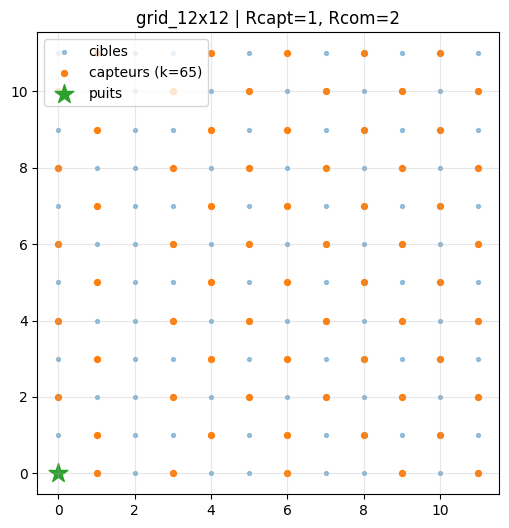

In [135]:
inst = make_grid(12, 12)
pc = build_precomp(inst, Rcapt=1, Rcom=2)

sol0 = greedy_construct(pc)
sol0 = repair(sol0, pc)
print('Greedy+repair:', int(sol0.sum()), 'capteurs, faisable?', is_feasible(sol0, pc))

sol1 = greedy_construct(pc)
sol1 = merge_sensors(sol1, pc)
print('Merge 2 en 1:', int(sol1.sum()), 'capteurs, faisable?', is_feasible(sol1, pc))

#sol = vns(pc, kmax=8, iters=40, do_swaps=True)
#print('VNS:', int(sol.sum()), 'capteurs, faisable?', is_feasible(sol, pc))

plot_solution(sol1, pc, show_links=False)

### Graphique: redondance de couverture

Histogramme du nombre de couvertures par cible.

Notes :
- Un pic a 1 indique une couverture minimale.
- Une queue longue vers la droite indique des zones sur-couvertes (potentiel de reduction).
- Si beaucoup de cibles ont une couverture >= 3, un pruning plus agressif peut aider.


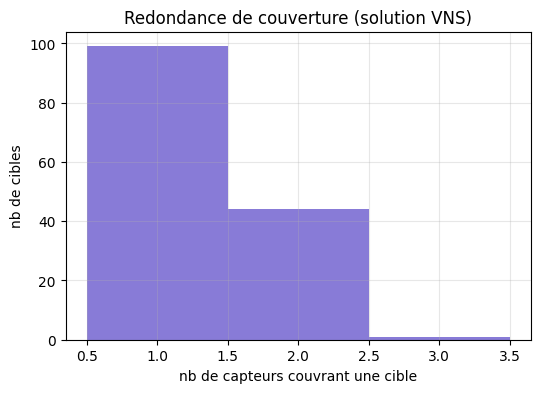

In [136]:
# Histogramme des niveaux de couverture pour la solution VNS
cov = compute_coverage_counts(sol, pc)
plt.figure(figsize=(6,4))
plt.hist(cov, bins=range(1, int(cov.max()) + 2), align='left', color='slateblue', alpha=0.8)
plt.xlabel('nb de capteurs couvrant une cible')
plt.ylabel('nb de cibles')
plt.title('Redondance de couverture (solution VNS)')
plt.grid(True, alpha=0.3)
plt.show()


## 12) Batterie d'expériences (tableau récapitulatif)

Structure :
- lignes = instances
- colonnes = approches (Greedy+prune, VNS)
- on reporte `k` (majorant) et le temps

Tu peux ajouter des instances tronquées et/ou charger les fichiers de points.

In [137]:
import time

def solve_greedy(pc: Precomp):
    t0 = time.time()
    sol = greedy_construct(pc)
    sol = repair(sol, pc)
    return sol, time.time() - t0

def solve_vns_fast(pc: Precomp, kmax: int = 5, iters: int = 15):
    t0 = time.time()
    sol = vns(pc, kmax=kmax, iters=iters, do_swaps=False)
    return sol, time.time() - t0

def run_benchmark_fast(instances, pairs, kmax: int = 5, iters: int = 15):
    rows = []
    for inst in instances:
        for Rcapt, Rcom in pairs:
            pc = build_precomp(inst, Rcapt=Rcapt, Rcom=Rcom)

            sol_g, tg = solve_greedy(pc)
            sol_v, tv = solve_vns_fast(pc, kmax=kmax, iters=iters)

            rows.append({
                "instance": inst.name,
                "N": inst.coords.shape[0],
                "Rcapt": Rcapt,
                "Rcom": Rcom,
                "Greedy_k": int(sol_g.sum()),
                "Greedy_time_s": round(tg, 3),
                "VNS_k": int(sol_v.sum()),
                "VNS_time_s": round(tv, 3),
            })
    return rows

pairs = [(1,2), (2,3)]
instances = [
    make_grid(10, 10, name="grid"),
    make_grid(20, 20, name="grid"),
    make_truncated_grid(20, 20, holes=[(6, 12, 8, 14)], name="trunc"),
]

rows = run_benchmark_fast(instances, pairs, kmax=5, iters=15)
rows[:3]


[{'instance': 'grid_10x10',
  'N': 100,
  'Rcapt': 1,
  'Rcom': 2,
  'Greedy_k': 45,
  'Greedy_time_s': 0.01,
  'VNS_k': 44,
  'VNS_time_s': 0.037},
 {'instance': 'grid_10x10',
  'N': 100,
  'Rcapt': 2,
  'Rcom': 3,
  'Greedy_k': 18,
  'Greedy_time_s': 0.003,
  'VNS_k': 14,
  'VNS_time_s': 0.058},
 {'instance': 'grid_20x20',
  'N': 400,
  'Rcapt': 1,
  'Rcom': 2,
  'Greedy_k': 190,
  'Greedy_time_s': 0.158,
  'VNS_k': 190,
  'VNS_time_s': 0.271}]

In [138]:
import pandas as pd
df = pd.DataFrame(rows)
df

,instance,N,Rcapt,Rcom,Greedy_k,Greedy_time_s,VNS_k,VNS_time_s
0,grid_10x10,100,1,2,45,0.010,44,0.037
1,grid_10x10,100,2,3,18,0.003,14,0.058
2,grid_20x20,400,1,2,190,0.158,190,0.271
3,grid_20x20,400,2,3,69,0.054,55,0.263
4,trunc_20x20_holes1,364,1,2,172,0.141,171,0.243
5,trunc_20x20_holes1,364,2,3,57,0.097,50,0.218


### Petit graphique : comparaison Greedy vs VNS

Notes :
- Si la courbe VNS est en dessous de Greedy, la metaheuristique ameliore bien le k.
- Si les deux courbes sont proches, l'instance est peut-etre simple ou deja bien couverte par Greedy.


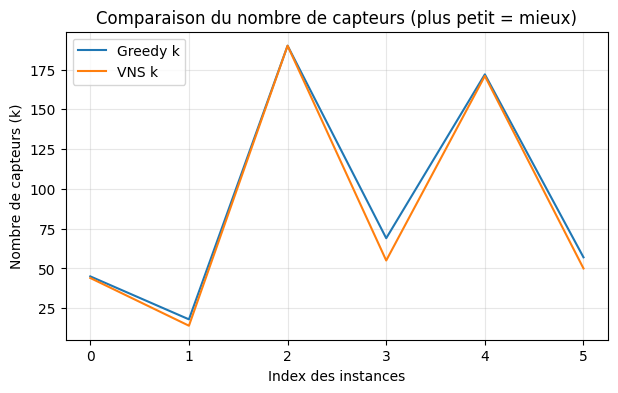

In [139]:
plt.figure(figsize=(7,4))
plt.plot(df['Greedy_k'].values, label='Greedy k')
plt.plot(df['VNS_k'].values, label='VNS k')
plt.xlabel('Index des instances')
plt.ylabel('Nombre de capteurs (k)') 
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Comparaison du nombre de capteurs (plus petit = mieux)')
plt.show()

### Graphique: compromis temps / qualite

Ce nuage de points compare la qualite (k) et le temps pour Greedy et VNS.
Objectif : petit k et petit temps.

Notes :
- VNS peut etre plus lent mais offrir un k plus petit.
- Si des points VNS dominent (plus bas et pas trop a droite), il vaut la peine d'augmenter iters.
- Si VNS est tres a droite sans gain en k, reduire kmax/iters est raisonnable.


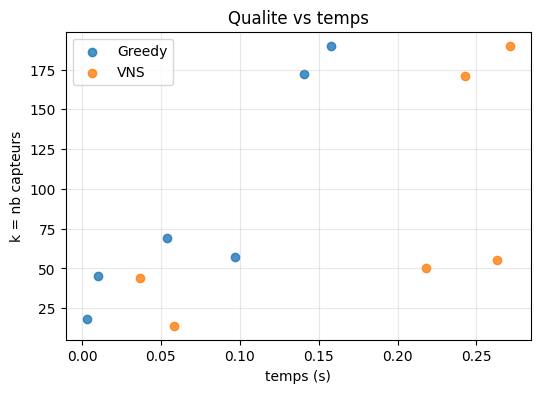

In [140]:
plt.figure(figsize=(6,4))
plt.scatter(df['Greedy_time_s'], df['Greedy_k'], label='Greedy', alpha=0.8)
plt.scatter(df['VNS_time_s'], df['VNS_k'], label='VNS', alpha=0.8)
plt.xlabel('temps (s)')
plt.ylabel('k = nb capteurs')
plt.title('Qualite vs temps')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
